# Modeling - Option 1:
## Predicting affluence in our NYC clusters

__Context and Motivation for this modeling exercise__:
In the prior Data Cleaning & Exploratory Data Analysis (EDA) notebook, we noted some interesting insights based on the relative percentages of business types in each NYC Borough.

__EDA Insights - Business Categories__:
- __Manhattan__ has a higher percentage of __coffee__ shops relative to other business types
- __Bronx__ and __Staten Island__ have a higher percentage of __pizza__ shops, relative to other types
- __Queens__ has a larger percentage of __Chinese__ restaurants, relative to other types
- __Staten Island__ has the highest percentage of __hot dog__ shops, relative to other types of businesses

__EDA Insights - Price Categories__:
- Manhattan has a predominance of __2 and 3 dollar-sign__ businesses 
- Bronx contains predominantly __1 dollar sign__ businesses.

We believe that these observations demonstrate that the relative distribution of types of businesses within a neighborhood and could be a predictor of affluence. Per our client's interest in predicting affluence based on the business types within a neighborhood, we will explore these types of questions via modeling methods in this Modeling Option 1 notebook.  We aim to help establish whether we can predict the affluence of the K-means 'clusters' developed earlier, with the larger end-goal of allowing our client to later use this method/model process for other cities or areas of interest.

We recognize that because we will be using aggregate business details, our observations will be limited by the number of clusters we created. We only have 80 observations/clusters, which is not ideal. Thus, we will pursue Modeling Option 2 in parallel (using each of our 20,000 businesses as observations).

__Model Option 1 - Results Overview__:
 In the present notebook we utilize ROC AUC as our measurement metric. We explore a variety of classification and tree-based prediction models. Our selected model is Logistic Regression with a ROC AUC of 0.869. We also explore Principal Component Analysis as a modeling option for our cluster dataset and uncover interesting business associations that are predictors of affluent neighborhoods.


## Import Libraries and Data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, roc_curve, auc, make_scorer, roc_auc_score

import matplotlib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

RANDOM_STATE = 42

### Load data

In [2]:
# Import our clean yelp data, with the cluster and 'is_affluent' columns

yelp = pd.read_csv('../data/yelp_clean.csv')

## Feature Engineering: creating fractional columns

In [3]:
# Quick view of the data set
yelp.head()

,Unnamed: 0,name,review_count,rating,price,cat1,zip_code,nyc,borough,cluster,is_affluent
0,0,Com Tam Ninh Kieu,379,4.0,2,vietnamese,10468,True,Bronx,12,0
1,1,Antonio's Trattoria,773,4.5,2,italian,10458,True,Bronx,12,0
2,2,Bronx Alehouse,749,4.0,2,tradamerican,10463,True,Bronx,62,0
3,4,The Bronx Public,443,4.0,2,sportsbars,10463,True,Bronx,62,0
4,5,Trattoria Zero Otto Nove,749,4.0,2,italian,10458,True,Bronx,12,0


In [4]:
# We define a function to calculate the percentage presence for each feature category across all the others
# In our current use case, the group is our cluster and the fraction is the % of the feature type (price or category)
def class_fraction_feature(df_feature, group_col, feature_col):
    '''Function to create percent features. Take in a data frame, df_feature, collect the 
    categories in the group_col identify the features in feature_col and give a percent of the feature for the group.
    '''
    # identify unique groups and the unique features
    groups   = df_feature[group_col].unique().tolist()
    features = df_feature[feature_col].unique().tolist()    
    
    # Create a dictionary to store the groups. Iterate through the groups and collect counts for the features
    data = []
    for g in groups:
        # empty dictionary, which will be filled with groups
        g_dict = {'group_col':g}
        
        for f in features:
            g_dict[f] = df_feature[(df_feature[group_col]==g)&(df_feature[feature_col]==f)][feature_col].count()
    
        # append the dictionary entry for a group to the list of groups
        data.append(g_dict)
        
    data = pd.DataFrame(data)
    
    # Create total by row and create fraction on each column
    data['total'] = data[features].sum(axis = 1)
    for f in features:
        data[ str(f) + '_fraction'] = data[f]/data['total']
   
    return data

In [5]:
# Using our fraction_feature function, we calculate the percentages for each business type:  
# by category type & price
cluster_price_fraction = class_fraction_feature(yelp,'cluster','price')
cluster_type_fraction = class_fraction_feature(yelp,'cluster','cat1')

In [6]:
# As an example, we show the fraction table for 'price'.
cluster_price_fraction.head()

,group_col,2,1,3,4,total,2_fraction,1_fraction,3_fraction,4_fraction
0,12,76,129,3,1,209,0.363636,0.617225,0.014354,0.004785
1,62,72,69,3,0,144,0.500000,0.479167,0.020833,0.000000
2,42,70,74,1,0,145,0.482759,0.510345,0.006897,0.000000
3,38,21,70,0,0,91,0.230769,0.769231,0.000000,0.000000
4,56,42,108,0,1,151,0.278146,0.715232,0.000000,0.006623


In [7]:
# Create a reference dataframe of the cluster numbers and their affluence category
cluster_is_affluent = yelp[['cluster', 'is_affluent']]
cluster_is_affluent = cluster_is_affluent.drop_duplicates(keep ='first')

In [8]:
# Join the fractions together to create a combined set for the clusters
cluster_fraction = cluster_price_fraction.merge(cluster_type_fraction, on = 'group_col', suffixes = ('_x','_y'))

# join on affluence
cluster_fraction = cluster_fraction.rename(columns={'group_col':'cluster'})
cluster_fraction = cluster_is_affluent.merge(cluster_fraction, on = 'cluster')

In [9]:
# We view the dataframe with all count and fractional columns. (We will remove some of these soon)
cluster_fraction.head()

,cluster,is_affluent,2,1,3,4,total_x,2_fraction,1_fraction,3_fraction,...,giftshops_fraction,spas_fraction,singaporean_fraction,diyfood_fraction,kids_activities_fraction,shopping_fraction,cookingschools_fraction,burmese_fraction,sicilian_fraction,farmersmarket_fraction
0,12,0,76,129,3,1,209,0.363636,0.617225,0.014354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62,0,72,69,3,0,144,0.500000,0.479167,0.020833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42,0,70,74,1,0,145,0.482759,0.510345,0.006897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38,0,21,70,0,0,91,0.230769,0.769231,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56,0,42,108,0,1,151,0.278146,0.715232,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the table above, we see a full dataframe with all the newly engineered fraction columns. We will add two more, based on grouping together the 1 & 2 dollar sign businesses, and 3 & 4 dollar sign businesses. Per the Exploratory Data Analysis we performed previously, this may help as an indicator of affluence.

In [10]:
# Adding two engineered columns based on dollar sign groupings
cluster_fraction['1_2_fraction'] = cluster_fraction['1_fraction'] + cluster_fraction['2_fraction']
cluster_fraction['3_4_fraction'] = cluster_fraction['3_fraction'] + cluster_fraction['4_fraction']

Next, we will utilize list comprehension to remove all of the original 'count' columns from our dataframe. 

In [11]:
# Remove columns that are based on count, vs fraction

cols = [c for c in cluster_fraction.columns if str(c).endswith('fraction')] # Keep columns with '_fraction'
cols.append('is_affluent') # ensure that our target 'is_affluent' category is maintained      

In [12]:
cluster_fraction = cluster_fraction[cols] # redefine our dataframe with the selected columns

In [13]:
# This our final goal dataframe - with all the fractional categories & the affluence (target) column
cluster_fraction.head()

,2_fraction,1_fraction,3_fraction,4_fraction,vietnamese_fraction,italian_fraction,tradamerican_fraction,sportsbars_fraction,desserts_fraction,mexican_fraction,...,diyfood_fraction,kids_activities_fraction,shopping_fraction,cookingschools_fraction,burmese_fraction,sicilian_fraction,farmersmarket_fraction,1_2_fraction,3_4_fraction,is_affluent
0,0.363636,0.617225,0.014354,0.004785,0.004785,0.081340,0.019139,0.014354,0.000000,0.071770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.980861,0.019139,0
1,0.500000,0.479167,0.020833,0.000000,0.000000,0.013889,0.034722,0.020833,0.020833,0.048611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.979167,0.020833,0
2,0.482759,0.510345,0.006897,0.000000,0.000000,0.013793,0.013793,0.013793,0.020690,0.089655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993103,0.006897,0
3,0.230769,0.769231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0
4,0.278146,0.715232,0.000000,0.006623,0.000000,0.013245,0.013245,0.006623,0.000000,0.052980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993377,0.006623,0


Above is our final dataframe, representing the ratio of business types for each cluster.  We will carry this forward to modeling. We will be exploring the relationship between the relative presence of business types as a prediction for affluence.

# Model Preparation

In [14]:
target = 'is_affluent'
X = cluster_fraction.drop(columns=target)
y = cluster_fraction[target]

# Train, Test Split

This is a small data set (only 80 observations). We will use 25% of the data set for testing.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

We utilize 'stratify' to ensure the train/test data sets have even distributions of classes. This is important due to the small size of the data set.

As a reminder, our positive class is 1 ('is affluent) while our negative class is 0 ('not affluent').

In [16]:
# We check the original distribution between the positive and negative class

y.value_counts(normalize=True)[0]

0.5316455696202531

In [17]:
# We also check the distribution for y_train
y_train.value_counts(normalize = True)

0    0.525424
1    0.474576
Name: is_affluent, dtype: float64

In [18]:
# We check the distribution for y_test
y_test.value_counts(normalize = True)

0    0.55
1    0.45
Name: is_affluent, dtype: float64

# Modeling

- We will first present our baseline model.  
- We will then develop several models, evaluating via GridSearch. 
- Based on the Grid Search's cross validation scores, we will then fine tune the hyper-parameters for each model to achieve the optimal result. 

## Evaluation Metric: ROC

A few notes about our chosen evaluation metric, ROC: 

- "ROC (Receiver Operating Characteristic) is a probability curve and AUC represents degree or measure of separability. It tells how well our model is capable of distinguishing between our classes"[(reference)](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5). The higher the ROC, and the better it the two classes: Affluent vs. Not Affluent. The ROC curve is plotted with True Positive Rate on y-axis, against the False Positive Rate on the x-axis.

- AUC (Area Under the Curve) measures the entire two-dimensional area underneath the entire ROC curve. The closer AUC to 1, the better the model.

- We are choosing the AUC ROC  as our metric, since our aim is to find the optimal model that best separates our Affluence classes.

##  Baseline Model

The baseline score for the ROC curve (our chosen evaluation metric) is 0.5. We will be assessing our model quality against this metric.

## Modeling Procedure

For each of the modeling steps below, we utilize a GridSearch methodology to assist in finding the best fit hyperparameters.

### Logistic Regression / GridSearch

In [19]:
# Setting up the pipeline for Logistic Regression modeling

pipe = Pipeline(steps=[ 
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_params ={
    'lr__C': [.00001, .0001, 0.0005, .001, .01],
    'lr__penalty' : ['l2', 'l1']
    }

gs_lr = GridSearchCV(pipe, 
                     pipe_params, 
                     cv=3,
                     scoring='roc_auc')


In [20]:
gs_lr.fit(X_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
# Check the optimal params
gs_lr.best_params_

{'lr__C': 0.0005, 'lr__penalty': 'l2'}

In [22]:
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=0.0005, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [23]:
# Train score
gs_lr.score(X_train, y_train)

0.9746543778801844

In [24]:
# Test score
gs_lr.score(X_test, y_test)

0.8686868686868686

In [25]:
# Cross val score on the whole dataset 
cv_lr = cross_val_score(gs_lr.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_lr

0.7934981684981685

Note that the small size of our data set makes cross-validation difficult. We are using cv = 3 (vs cv = 5) to minimize the issues, but in general, it is good to keep in mind that the cross-validation scores may not be valid across the board.

In [26]:
# extract the coefficients from our Logistic Regression model
coef_lr_gs = np.array((gs_lr.best_estimator_.named_steps['lr']).coef_).tolist()[0]

In [27]:
# extract the categories for our coefficients
names = X_train.columns

In [28]:
# Zip the coefficients and column names together
gs_lr_betas = list(zip(names, coef_lr_gs))

In [29]:
# Create final dataframe of words with their corresponding coefficients
gs_lr_coefs = pd.DataFrame(gs_lr_betas).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = False)

In [30]:
gs_lr_coefs[gs_lr_coefs['coef'] != 0].head(10)

,word,coef
80,french_fraction,0.008075
102,cocktailbars_fraction,0.006967
107,ramen_fraction,0.006921
153,beerbar_fraction,0.006476
36,cafes_fraction,0.006452
10,coffee_fraction,0.005964
33,wine_bars_fraction,0.005906
84,venues_fraction,0.005838
156,musicvenues_fraction,0.005832
65,vegetarian_fraction,0.005507


Per our logistic model, the above features are the strongest predictors for the positive class ('is affluent'). The top predictors of affluence are french restaurants, cocktail bars & ramen shops. Cafes and Coffee shops also have a strong presence, along with wine and beer bars. This is intuitively sensible, as these types of business would typically be frequented by people with extra expendible income. People who are affluent would be more able to sustain upscale alcohol establishments (cocktail and wine bars) and cafes in their neighborhood.

The top predictor for affluence is French restaurants, with a coefficient of .008075.  For a one-unit (aka percentage) increase in the relative French restaurants among the businesses in an area, the area is e^(0.008075) times as likely to be affluent. 


In [31]:
# Looking at the 'top' predictors of the Negative class
gs_lr_coefs[gs_lr_coefs['coef'] != 0].tail(6).sort_values('coef', ascending = True) 

,word,coef
15,pizza_fraction,-0.006340
55,hotdogs_fraction,-0.005658
56,donuts_fraction,-0.005330
1,1_fraction,-0.005025
29,diners_fraction,-0.004379
13,comfortfood_fraction,-0.004186


Here we see the strongest predictors for the negative class ('not affluent'). The top predictors of 'not affluent' areas are the fraction of pizza restaurants, hot dog shops, donut shops & 1-dollar sign businesses in general. This is intuitively sensible as they provide quick and inexpensive food options for residents of the area. The percentage of 1-dollar sign business is particularly intuitively relevant as a predictor of a non-affluent neighborhood.

The top predictor of a non-affluent neighborhood is 'Pizza' restaurants, with a coefficient of -0.00634. For a one-unit (aka percentage) increase in the relative Pizza restaurants among the businesses in an area, the area is e^(-.00634) times as likely not to be affluent. 

### KNN modeling / GridSearch

In [32]:
# Setting up the pipeline for K-Nearest Neighbors Grid Search and modeling
pipe_knn = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_params_knn ={
    'knn__n_neighbors' : [5, 10, 15, 20]
    
}

gs_knn = GridSearchCV(pipe_knn, 
                      pipe_params_knn, 
                      cv=3,
                      scoring='roc_auc')

In [33]:
# Running the KNN model
gs_knn.fit(X_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
# Check the optimal parameters
gs_knn.best_params_

{'knn__n_neighbors': 15}

In [35]:
# Train score
gs_knn.score(X_train, y_train)

0.9164746543778802

In [36]:
# Test score
gs_knn.score(X_test, y_test)

0.8636363636363636

In [37]:
# Cross val score on the whole dataset 
cv_knn = cross_val_score(gs_knn.best_estimator_, X, y, scoring='roc_auc', cv=5).mean()
cv_knn

0.7557539682539682

For our KNN model, we again see that the cross-validation score is not close to the train/test scores, which is problematic. This is likely due in part to the small size of the data set, which makes statistical modeling difficult.

### Decision Tree / GridSearch

In [38]:
# Setting up the pipeline for DecisionTree Grid Search and modeling
pipe_dt = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('dt', DecisionTreeClassifier(random_state=42))
])

pipe_params_dt = {
    'dt__max_depth': [3, 4, 5],
    'dt__min_samples_split': [2, 3, 4],
    'dt__min_samples_leaf': [1, 5, 10]}

gs_dt = GridSearchCV(pipe_dt, 
                     pipe_params_dt, 
                     cv=3,
                     scoring='roc_auc')

In [39]:
# Running the Decision Tree fit
gs_dt.fit(X_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [40]:
# Check the optimal params
gs_dt.best_params_

{'dt__max_depth': 3, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}

In [41]:
# Train score
gs_dt.score(X_train, y_train)

0.9475806451612903

In [42]:
# Test score
gs_dt.score(X_test, y_test)

0.7929292929292929

In [43]:
# Cross val score on the whole dataset 
cv_dt = cross_val_score(gs_dt.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_dt

0.7343559218559218

This model is distinctly overfit, as is typical for Decision Tree models. The Training score is 15% higher than the Testing score, which indicates that we've too strongly fit to our training data set. 

### Bagging Classifier / GridSearch

In [44]:
# Setting up the pipeline for Bagging Classifier Grid Search and modeling
pipe_bc = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('bc', BaggingClassifier(random_state=42))
])

pipe_params_bc = {
    'bc__n_estimators': [5, 10, 15],
    'bc__max_samples': [1, 2, 3]}

gs_bc = GridSearchCV(pipe_bc, 
                     pipe_params_bc, 
                     cv=3,
                     scoring='roc_auc')

In [45]:
# Running the Bagging Classifer model
gs_bc.fit(X_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [46]:
# Check the optimal hyperparameters
gs_bc.best_params_

{'bc__max_samples': 3, 'bc__n_estimators': 15}

In [47]:
# Training score
gs_bc.score(X_train, y_train)

0.8513824884792627

In [48]:
# Testing score
gs_bc.score(X_test, y_test)

0.8282828282828282

In [49]:
# Cross val score on the whole dataset 
cv_bc = cross_val_score(gs_bc.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_bc

0.764957264957265

The Bagging Classifer model is giving us the closest Train and Test scores to date. While it isn't the best fit, it is reasonably reproducible. Once again, the Cross Validation score is lower than ideal, possibly due to the small size of the data set.

### Random Forest / GridSearch

In [50]:
pipe_rf = Pipeline(steps=[ 
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_params_rf = {
    'rf__max_depth': [2, 3, 4],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [5, 8, 10]}


gs_rf = GridSearchCV(pipe_rf, 
                     pipe_params_rf, 
                     cv=3,
                     scoring='roc_auc')

In [51]:
gs_rf.fit(X_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [52]:
# Check the optimal params
gs_rf.best_params_

{'rf__max_depth': 2, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2}

In [53]:
# Train score
gs_rf.score(X_train, y_train)

0.9262672811059908

In [54]:
# Test score
gs_rf.score(X_test, y_test)

0.7777777777777777

In [55]:
# Cross val score on the whole dataset 
cv_rf = cross_val_score(gs_rf.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()
cv_rf

0.8260836385836385

The Random Forest model is also proving to be considerably overfit, as shown by the significant difference between the train and test scores. 

## Model Comparison Summary

In this brief section, we highlight the final test, train and cross-validation scores for of the fitted models.

#### Training Scores:

In [56]:
# Evaluate Training Scores for each Classification Model
print('Training Scores:')
print(f'Logistic Regression:                          {gs_lr.score(X_train, y_train):.3f}')
print(f'K-Nearest Neighbors Classification:           {gs_knn.score(X_train, y_train):.3f}')
print(f'Decision Tree Classification:                 {gs_dt.score(X_train, y_train):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {gs_bc.score(X_train, y_train):.3f}')
print(f'Random Forest Classification:                 {gs_rf.score(X_train, y_train):.3f}')


Training Scores:
Logistic Regression:                          0.975
K-Nearest Neighbors Classification:           0.916
Decision Tree Classification:                 0.948
Set of Bagged Decision Trees Classification:  0.851
Random Forest Classification:                 0.926


Per above, we are observing generally good ROC AUC scores for our training data - each (with the exception of the Bagged Decision Tree) is above 0.9, which is considerably better than our baseline model of 0.5. That said, training data doesn't give us the whole story. We need to check the testing scores to ensure we aren't overfitting.

#### Testing Scores:

In [57]:
# Evaluate Testing Scores for each Classification Model
print('Testing Scores:')
print(f'Logistic Regression:                          {gs_lr.score(X_test, y_test):.3f}')
print(f'K-Nearest Neighbors Classification:           {gs_knn.score(X_test, y_test):.3f}')
print(f'Decision Tree Classification:                 {gs_dt.score(X_test, y_test):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {gs_bc.score(X_test, y_test):.3f}')
print(f'Random Forest Classification:                 {gs_rf.score(X_test, y_test):.3f}')


Testing Scores:
Logistic Regression:                          0.869
K-Nearest Neighbors Classification:           0.864
Decision Tree Classification:                 0.793
Set of Bagged Decision Trees Classification:  0.828
Random Forest Classification:                 0.778


Per above, we see that the models are generally overfitting to some extent. The strongest Test Score is observed for the Logistic Regression Model. The least overfit model is the Bagged Decision Tree model.

#### Cross Validation Scores:

In [58]:
# Evaluate Cross Validation scores for each Classification Model
print('Training Scores:')
print(f'Logistic Regression:                          {cv_lr:.3f}')
print(f'K-Nearest Neighbors Classification:           {cv_knn:.3f}')
print(f'Decision Tree Classification:                 {cv_dt:.3f}')
print(f'Set of Bagged Decision Trees Classification:  {cv_bc:.3f}')
print(f'Random Forest Classification:                 {cv_rf:.3f}')


Training Scores:
Logistic Regression:                          0.793
K-Nearest Neighbors Classification:           0.756
Decision Tree Classification:                 0.734
Set of Bagged Decision Trees Classification:  0.765
Random Forest Classification:                 0.826


As noted previously, the cross-validation scores are not necessarily reliable with such a small data set. That said, each of them is higher than the baseline ROC AUC score (0.5). At this stage, we see the highest cross-validation score with the Random Forest Classification Model. The next highest score is seen with the Logistic Regression Model.

## Model Selection

At this stage, we will select the Logistic Regression Model. Some reasoning behind our choice:
- Despite a moderate level of overfitting, among all of the models, the Logistic Classification had the highest overall combination of training, testing and cross-validation scores. In addition, it is the most interpretable of the models, as shown above, where we are able to extract clear information about the individual coefficients that predict affluence.


## Model Evaluation

In this section, we will fully evaluate the results of our selected model, Logistic Classification. We will review the resulting Confusion Matrix as well as the AUC ROC (Receiver Operating Characteristic) curve.

### Confusion Matrix

In [59]:
# Setting up the predictions for a Confusion Matrix

y_pred = gs_lr.predict(X_test)

In [60]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

In [61]:
cm = confusion_matrix(y_test, y_pred)

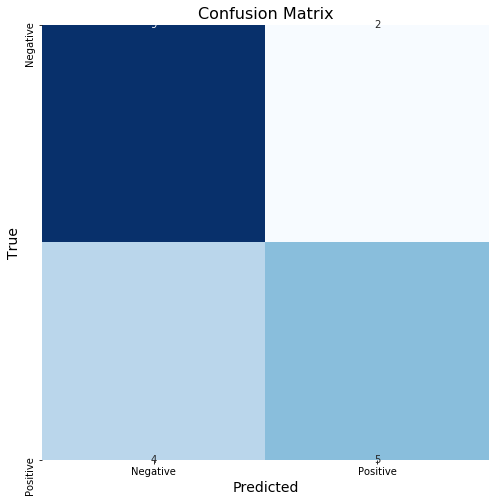

In [62]:
plt.figure(figsize = (8,8))
ax = plt.subplot()
sns.heatmap(cm, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('True', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

Via the confusion matrix, we observe that our model is better at predicting the Negative Class than the Postive Class. More work could be done to understand this finding. As a further phase, it may even be worthwhile to explore a separate modeling exercise in which we choose Sensitivity a our metric - where we would focus on maximizing the True Positive rate - and further refining the features that are uniquely predictive of the positive/affluent class.

### ROC Curve and AUC ROC

In [63]:
# We establish the probabilities to be used to create the ROC curve
y_pred_proba = gs_lr.predict_proba(X_test)

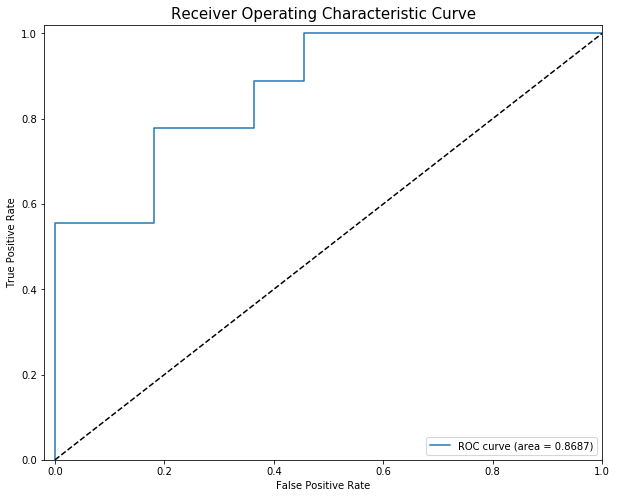

In [64]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)


# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize=15)
plt.legend(loc="lower right");

Above is the final ROC curve for our selected model. The AUC ROC is 0.8687, which is considerably better than the baseline (0.5). The ROC 'curve' is distinctly not smooth - it is instead choppy / digitized in appearance. This is a remnant of the small sample size (only 80 observations).

Thus, while our Logistic Classification model is reasonably in terms of overall prediction (via the ROC AUC metric), it is clearly not an optimal data set. Thus, we will continue forward with an alternate approach in a secondary modeling method in a separate notebook (Modeling Option 2).

 ## Additional Modeling / EDA: Principal Component Analysis

While not a core part of our original model selection process, due to the dimensions of our present data set (80 observations, with ~260 features), we have decided to show an initial exploration of Principal Component Analysis

In [65]:
# Scaling our Data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)


### Model with Principal Components (keeping 99% of original variance)

Below, we establish a Principal Component Analysis model that explains 99% of the original variance

In [93]:
# Instantiate PCA
pca_99 = PCA(n_components = .99, random_state = RANDOM_STATE)

Z_train_99 = pca_99.fit_transform(X_train_ss)
Z_test_99  = pca_99.transform(X_test_ss)

In [94]:
# creation of a a covariance DataFrame
pd.DataFrame(pca_99.get_covariance()).head()

,0,1,2,3,4,5,6,7,8,9,...,252,253,254,255,256,257,258,259,260,261
0,1.475178,-0.876865,0.449213,0.328663,0.290355,0.504166,0.151359,0.132822,0.182648,-0.142756,...,0.0,0.0,0.108375,0.071084,-0.010575,0.039766,-0.042691,0.203299,-0.459438,0.459438
1,-0.876865,1.497365,-0.727887,-0.531564,-0.247526,-0.606476,-0.150629,-0.116068,-0.143836,0.271260,...,0.0,0.0,-0.060441,-0.207805,0.046738,0.014520,0.002130,-0.257032,0.744234,-0.744234
2,0.449213,-0.727887,1.489310,0.546557,0.092378,0.554359,0.064320,0.036833,0.009215,-0.398291,...,0.0,0.0,-0.044280,0.315067,-0.095217,-0.105688,0.068742,0.261736,-0.937230,0.937230
3,0.328663,-0.531564,0.546557,1.496548,0.022920,0.373523,0.175563,0.060972,0.078095,-0.219372,...,0.0,0.0,-0.022915,0.421079,-0.042382,-0.048500,0.038614,0.134360,-0.683407,0.683407
4,0.290355,-0.247526,0.092378,0.022920,1.438178,0.266172,-0.048124,0.000176,0.220794,-0.078044,...,0.0,0.0,0.026819,-0.006591,-0.088048,-0.066924,-0.076931,-0.014719,-0.084486,0.084486


Eigenvalues denote the relative importance of the associated principal component.

The explained variance for each principal component is 
$$\frac{\lambda_i}{\lambda_{total}}$$


In [92]:
# isolating the eigenvalues (proportion of explained variance for associated principal component)
var_exp = pca_99.explained_variance_ratio_

# determining the cumulative eigenvalues & summarizing in a dataframe
cum_var_exp = np.cumsum(var_exp)
pd.DataFrame({"explained_variance": var_exp, "cumulative_exp_var": cum_var_exp}, index = [f"PC{i+1}" for i in range(len(var_exp))])

,explained_variance,cumulative_exp_var
PC1,0.087318,0.087318
PC2,0.047903,0.135222
PC3,0.041967,0.177188
PC4,0.037440,0.214629
PC5,0.035834,0.250463
PC6,0.032818,0.283281
PC7,0.029469,0.312749
PC8,0.028431,0.341180
PC9,0.027176,0.368356
PC10,0.026570,0.394926


The above dataframe indicates that we can explain 99% of the variance of our dataset with 55 principal components, which is a clear improvement over the original 262. 

Next, we make use of a Scree plot to visualize the proportion of total variance explained by each Principal Component

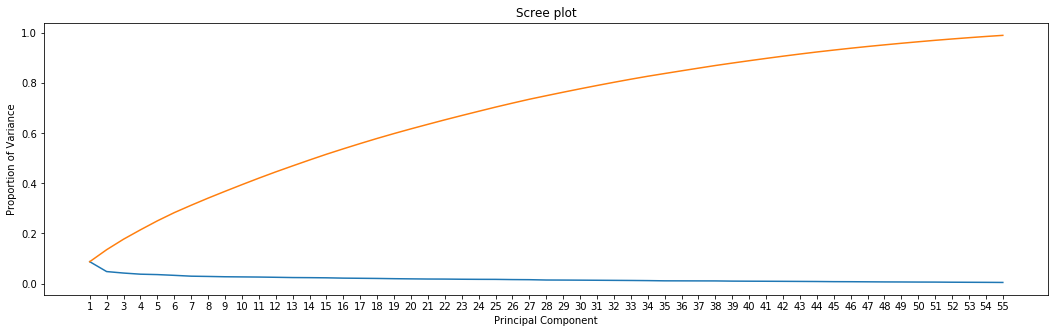

In [95]:
# Scree plot
plt.figure(figsize=(18,5))
plt.title("Scree plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance")
x_tick_range = range(1,len(var_exp) + 1)
plt.plot(x_tick_range,var_exp)
plt.plot(x_tick_range,cum_var_exp)
plt.xticks(x_tick_range);

The above Scree plot helps us visualize the impact of each individual Principal Component. We see that it takes many components to give a complete explanation of the variance. However, it clearly takes fewer components than the number of features in our full dataset (262).

In [104]:
# Checking the score for the Principal Component Analysis model
lr_pca_99 = LogisticRegression(random_state=RANDOM_STATE)
lr_pca_99.fit(Z_train_99, y_train)
lr_pca_99.score(Z_test_99, y_test)

0.65

We obtain an Accuracy score of 0.65. 

In [105]:
# A check: How many components are we using?
len(pca_99.components_)

55

We obtain an accuracy score of 0.65 using 21% (or 55 / 262) of the number of features of our original model (note that this is scoring accuracy, vs ROC AUC, as we had used above)

We would not necessarily consider this to be a strong score (relative to a baseline accuracy metric of 0.53), but it will be worthwhile to investigate the key principal components.

In [106]:
# Create a dataframe that contains our individual Principal Components
loadings = pca_99.components_.T * np.sqrt(pca_99.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns = [f"PC{i + 1}" for i in range(loadings.shape[1])],index=X.columns)
loading_matrix.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55
2_fraction,0.730013,0.088612,-0.088008,0.239159,-0.132127,-0.249274,0.135426,-0.077293,0.044197,-0.028522,...,-0.051611,-0.047043,-0.015553,-0.073404,-0.021369,-0.109826,-0.057965,0.027324,0.034590,-0.024361
1_fraction,-0.836276,-0.139445,0.278098,-0.105704,0.087989,0.161602,-0.086062,0.075990,-0.037880,0.017870,...,0.038169,0.025354,-0.005314,0.056863,0.007279,0.094059,0.035625,-0.023307,-0.018996,0.023143
3_fraction,0.643017,0.194220,-0.507609,-0.105711,0.076087,-0.017745,0.015344,-0.090691,0.037972,-0.009777,...,-0.010349,0.007286,0.039961,-0.008475,0.022791,-0.036171,0.010319,0.000241,0.001260,-0.012479
4_fraction,0.716263,0.037350,-0.287656,-0.309064,-0.206366,0.275884,-0.189887,0.142141,-0.086199,0.067796,...,0.033528,0.064992,0.020434,-0.003210,-0.000989,-0.008469,0.029100,0.034747,-0.069498,-0.008594
vietnamese_fraction,0.310308,0.443646,0.325221,0.050782,0.041169,-0.264319,0.115831,-0.071773,-0.086367,-0.188964,...,-0.168064,-0.070716,0.102349,0.017859,0.087877,0.011726,0.088695,-0.071638,-0.086868,0.056209


### Ranking the Principal Components in order of correlation with our target (affluence)

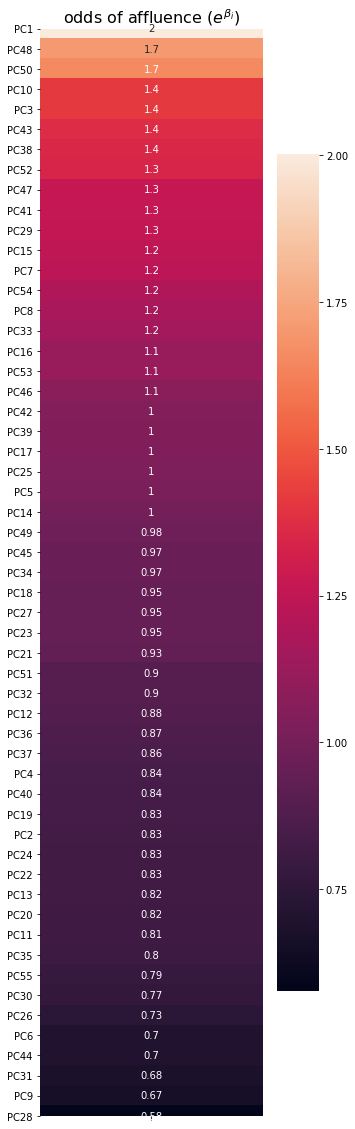

In [99]:
# Create a sorted heatmap based on correlation with our target
coefs = pd.DataFrame([np.exp(num) for num in lr_pca_99.coef_[0]], index = [f"PC{i + 1}" for i in range(loadings.shape[1])], columns = ["coefs"])
plt.figure(figsize=(5,20))
plt.title("odds of affluence ($e^{\\beta_i}$)", fontsize = 16)
sns.heatmap(coefs.sort_values("coefs", ascending = False), annot = True, xticklabels=[""]);

We see that $PC1$ and $PC48$ are most highly positively correlated with our target. 

- The Logistic Regression model coefficients suggest with a unit increase in $PC1$, we can expect that the corresponding area (aka cluster) is 2 times as likely to be affluent.
- With a unit increase in $PC48$, we can expect that the corresponding area (cluster) is 1.7 times as likely to be affluent.

We will further interpret these two features.

We will also investigate $PC28$ (the bottom of the scale), for which we can expect that the corresponding area (aka cluster) is 0.58 times as likely to be affluent for each unit increase in $PC28$ (this is additionally the Principal Component that is least likely to be affluent for each unit increase in $PC28$).

### Interpreting PC1

We can investigate which (group of) features are highly correlated (both positively and negatively) with $PC1$. 

In [75]:
# Let's review the features associated with PC1
loading_matrix.sort_values(by="PC1", ascending = False)[["PC1"]].head(10)

,PC1
french_fraction,0.793941
wine_bars_fraction,0.756888
2_fraction,0.730013
4_fraction,0.716263
3_4_fraction,0.712654
gaybars_fraction,0.684986
ramen_fraction,0.655467
newamerican_fraction,0.644714
3_fraction,0.643017
chocolate_fraction,0.616830


In [76]:
# how much does PC1 explain the total variance?
pca_99.explained_variance_ratio_[0] # 1st component

0.08731848873080342

__PC1 Interpretation - positive predictors of affluence:__ 
- On its own, PC1 explains ~9% of the total variance 
- It appears the most significant features correlating with the __1st Principal Component are french/wine related as well as related to higher price points.__  These are familiar results! These business categories are similar to what we had obtained via our non-PCA Logistic Regression model during our model selection process. 
- Since these features are highly correlated to the Principal Component that contributes the largest portion of the explained variance, it's _very likely_ (not guaranteed) that these features will be important in predicting the target.


In [77]:
# Looking for negative correlations with 
loading_matrix.sort_values(by="PC1", ascending = False)[["PC1"]].tail(5)

,PC1
pizza_fraction,-0.574911
donuts_fraction,-0.583510
hotdogs_fraction,-0.667309
1_2_fraction,-0.712654
1_fraction,-0.836276


__PC1 Interpretation - negative predictors of affluence:__ 
On the opposite end of PC1, we again see familiar categories - similar to the features obtained via Logistic Regression in our full model comparison process. As mentioned earlier, we are not surprised that these features are negatively associated with affluence, as they are lower-priced and quick food options.

### Interpreting PC48

Next, we will review which (group of) features are highly correlated (both positively and negatively) with $PC48$. 

In [100]:
# how much does PC48 explain the total variance?
pca_99.explained_variance_ratio_[47] # 47th in the list is PC48

0.006531800633679118

It is good to note that on its own, PC48 explains just 0.65% of the total variance. Despite this minimal impact on explaining variance, it is the 2nd best as a predictor for affluence.

In [79]:
# Reviewing the feature components
loading_matrix.sort_values(by="PC48", ascending = False)[["PC48"]].head(10)

,PC48
ethiopian_fraction,0.294094
bookstores_fraction,0.253398
hawaiian_fraction,0.241076
gelato_fraction,0.210182
kosher_fraction,0.210145
tapas_fraction,0.195148
panasian_fraction,0.188049
peruvian_fraction,0.176734
desserts_fraction,0.174574
pastashops_fraction,0.168429


__PC48 Interpretation - positive predictors of affluence:__
From the PCA model, we know that this group of features has relative significance for predicting affluence. However, they are not necessarily expected or intuitive! It seems that ethiopian restaurants, bookstores, hawaiian & peruvian restaurants are together positively correlated with affluence. One might collectively term these as somewhat international/exotic business or restaurant types.

In [80]:
# Interpretation
loading_matrix.sort_values(by="PC48", ascending = False)[["PC48"]].tail(5)

,PC48
african_fraction,-0.170592
greek_fraction,-0.177204
asianfusion_fraction,-0.231780
cupcakes_fraction,-0.249341
petstore_fraction,-0.270514


__PC48 Interpretation - negative predictors of affluence:__ 
- We see that petstores, cupcake shops as well as asian fusion, greek & african restaurants are generally opposing the features we found above (ethiopian restaurants, bookstores, hawaiian restaurant). Again, this is not intuitive, but is interesting to contemplate. On the other end of the spectrum, one might view pet stores, cupcake shops & Asian Fusion as less international / exotic businesses.


### Interpreting PC28

Next, we will review which (group of) features are highly correlated (both positively and negatively) with $PC28$. 

In [101]:
# how much does PC28 explain the total variance?
pca_99.explained_variance_ratio_[27] # 27th in the list is PC28

0.014158769652734899

PC28 explains 1.4% of the total variance.

In [87]:
# Reviewing the feature components
loading_matrix.sort_values(by="PC28", ascending = False)[["PC28"]].head(10)

,PC28
modern_european_fraction,0.334257
spas_fraction,0.315960
turkish_fraction,0.223316
lounges_fraction,0.220900
divebars_fraction,0.214704
soup_fraction,0.210686
hotdog_fraction,0.206425
seafood_fraction,0.194002
tradamerican_fraction,0.192243
kitchenandbath_fraction,0.191808


From the PCA model, we know that this group of features is least significant for predicting affluence. We see businesses such as Modern European restaurants, turkish businesses as well as spas & lounges. While these may seem rather luxury in nature, per our New York City data, they do not predict a neighborhood of affluence. Further down the list are Dive Bars and Hot Dogs, which are more self explanatory in not be associated with 'affluence'.

In [103]:
# Interpretation
loading_matrix.sort_values(by="PC28", ascending = False)[["PC28"]].tail(5)

,PC28
southern_fraction,-0.282559
golf_fraction,-0.300533
tattoo_fraction,-0.301325
landmarks_fraction,-0.336494
asianfusion_fraction,-0.387815


On the other side of this Principal Component are businesses that similar could be considered not predictive of affluence, such as Southern Food, Golf, and Tattoo Parlors. 

### Principal Component Analysis - concluding thoughts

The Principal Component Analysis has confirmed the key features that we had observed and interpreted via our original Logistic Regression Model. Features like French Restaurants, Wine Bars, 4-dollar sign restaurants, ramen restaurants are shown to be positively correlated with affluence. Businesses like pizza and hotdog shops as well as 1 and 2 dollar sign businesses are shown to be oppositely correlated with affluence. 

While the other principal components we investigated were less intuitive, the analysis of PC1 was good confirmation for us. It could be worthwhile to review additional components at a later date.

___________

## Conclusion - Model Option 1

In this notebook, we investigated whether the types of businesses in an area (by relative proportion) can predict whether an area is affluent. To facilitate this analysis, we utilized the K-means clusters developed previously - in which businesses in an area were grouped together across NYC. 

For each of our 80 clusters, we broke out the percentages of the businesses in two ways 1) by business category, 2) by business price. This resulted in ~260 additional columns, each of which was populated with a fractional number (the % presence of that business type among all businesses in the area/cluster). 

When configured in this matter, the data set is relatively small, by typical data science standards, making it challenging to avoid overfitting & to attain reasonable cross validation scores. However, per the subsequent analysis, we proceeded to obtain excellent insights into the business types that predict affluence in a region. 

We evaluated our data set via several Classification methods. We utilized ROC AUC as our modeling metric (keeping in mind our baseline of 0.5) - and analyzed via the following methods: Logistic Regression, K-nearest Neighbors, Decision Tree, Bagging Classifier, and Random Forest (all with Grid Search). We ultimately selected Logistic Regression as our final model, due to overall balance of training, testing and cross-validation scores. The ROC AUC score for our selected model, Logistic Regression, was 0.869. 

Via Logistic Regression, we discovered numerous business types that are predictive of affluence in our NYC-based areas. The top predictors of affluence were french restaurants, cocktail bars and ramen shops. Cafes and Coffee shops also had a strong presence, along with wine and beer bars. This is intuitively sensible, as these types of business would typically be frequented by people with extra expendible income. People who are more affluent would be more able to sustain upscale alcohol establishments (cocktail and wine bars) and cafes.

We also discovered business types that are predictive of the negative class ('not affluent'). The top predictors of 'not affluent' areas are the fraction of pizza restaurants, hot dog shops, donut shops & 1-dollar sign businesses in general. This is intuitively sensible as these types of businesses provide quick and inexpensive food and product options. 

As a supplemental analysis, motivated by the unusual size of our data set (many features, few observations), we also explored Principal Component Analysis. We determined that 99% of our feature's variance can be explained by just 56 principal components (relative to the ~260 original features). We closely investigated the two principal components that were most highly correlative with predicting affluence. It was affirming to find that the the most significant features to predict affluence (via the 1st Principal Component) are french/wine related as well as related to higher price points. On the opposite end of the same Principal Component, we again saw familiar busines types - similar to the features obtained via Logistic Regression in our full model comparison process (i.e., 1 dollar sign businesses, pizza, hotdogs and donuts). As mentioned earlier, we are not surprised that these features are negatively associated with affluence, as they are lower-priced and quick food options.

Despite the non-ideal nature of our modeling data set, we are satisfied by our model performance. We were able to attain a ROC AUC that is considerably better than our baseline. We found great insights into the nature of the types of businesses that are prominent (from a percentage perspective) in affluent NYC neighborhoods. Going forward, our client could leverage this type of modeling methodology to assess other cities in similar way, yielding  insights into the distinct features that relate to 'affluence' in other cities.

As an alternate, quicker, and more statistical modeling approach, we will also pursue a Modeling Option 2, where we make predictions based on the entire set of businesses in NYC.